#### Kurtosis Analysis & Gaussian "Central" Fit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

def kurtosis_data(x):
    mean = np.mean(x)
    std = np.std(x, ddof=0)
    return np.mean(((x - mean) / std)**4)

tot_time = 180
t_stat = 10 # We suppose at this time the system got into an stationary state
tot_runs = 100
fmag = 7.2

# Extract Relevant Data from Sample
dir_sample = r"./mag&freq/" + r"/data_fmag1_ffreq3_2runs/" + "results.csv"
sample = pd.read_csv(dir_sample)
tot_frames = len(sample["frame"].tolist())/2
time_per_frame = tot_time / tot_frames
time_array = np.linspace(0, int(tot_time), int(tot_frames))

# General data for stationary analysis
t_stat_idx = np.argmin(np.abs(time_array - t_stat))
n_data = len(time_array[t_stat_idx:-1])

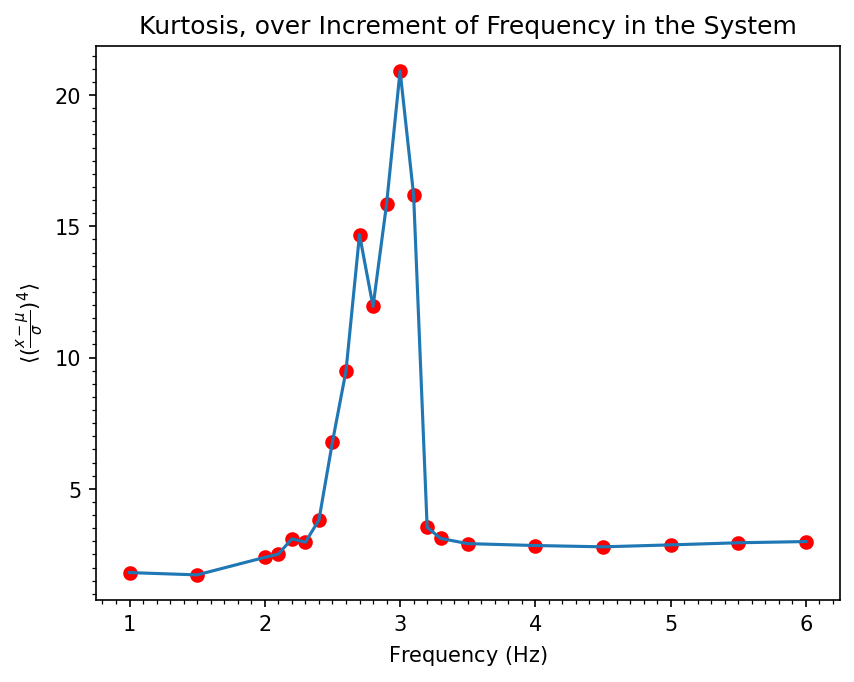

In [2]:
freqs_kurt = [1, 1.5, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.5, 4, 4.5, 5, 5.5, 6]
kurt = np.zeros(len(freqs_kurt))

for idx, freq in enumerate(freqs_kurt):
    
    dir_data = r"./mag&freq/" + f"/data_fmag{fmag}_ffreq{freq}_{tot_runs}runs/" + "results.csv"
    data = pd.read_csv(dir_data)
    x_array = np.zeros(tot_runs * n_data)
    
    for i in range(tot_runs):
        part = data[data["run_number"] == i + 1]
        x_part = np.array(part.x_pos.tolist())
        x_part = x_part - x_part[0]
        x_array[n_data * i : n_data * (i + 1)] = x_part[t_stat_idx:-1]
    
    kurt[idx] = kurtosis_data(x_array)

plt.figure(dpi=150)
plt.plot(freqs_kurt, kurt)
plt.scatter(freqs_kurt, kurt, color="r")
plt.title("Kurtosis, over Increment of Frequency in the System")
plt.xlabel(r"Frequency ($\text{Hz}$)")
plt.ylabel(r"$\langle (\frac{x - \mu}{\sigma})^4 \rangle$")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1.00)) # Showing the number
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1)) # Not showing the number
ax.yaxis.set_major_locator(ticker.MultipleLocator(5)) # Showing the number
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5)) # Not showing the number
plt.show()

#### Gaussian "Central" Fit Implementation

In [3]:
from scipy.optimize import curve_fit

def tri_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3):
    gauss1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    gauss2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
    gauss3 = A3 * np.exp(-(x - mu3)**2 / (2 * sigma3**2))
    return gauss1 + gauss2 + gauss3

In [4]:
# Get function as a curve - Example
freq_ex = 1
dir_data = r"./mag&freq/" + f"/data_fmag{fmag}_ffreq{freq_ex}_{tot_runs}runs/" + "results.csv"
data = pd.read_csv(dir_data)
x_array = np.zeros(tot_runs * n_data)
num_bins = 65 # "Resolution", number of classes

for i in range(tot_runs):
    part = data[data["run_number"] == i + 1]
    x_part = np.array(part.x_pos.tolist())
    x_part = x_part - x_part[0]
    x_array[n_data * i : n_data * (i + 1)] = x_part[t_stat_idx:-1]

counts_ex, bin_edges = np.histogram(x_array, bins=num_bins, density=True)
x_ex = 0.5 * (bin_edges[1:] + bin_edges[:-1])

We try the Gaussian Mixture Model, GMM, to find the separated guassian functions

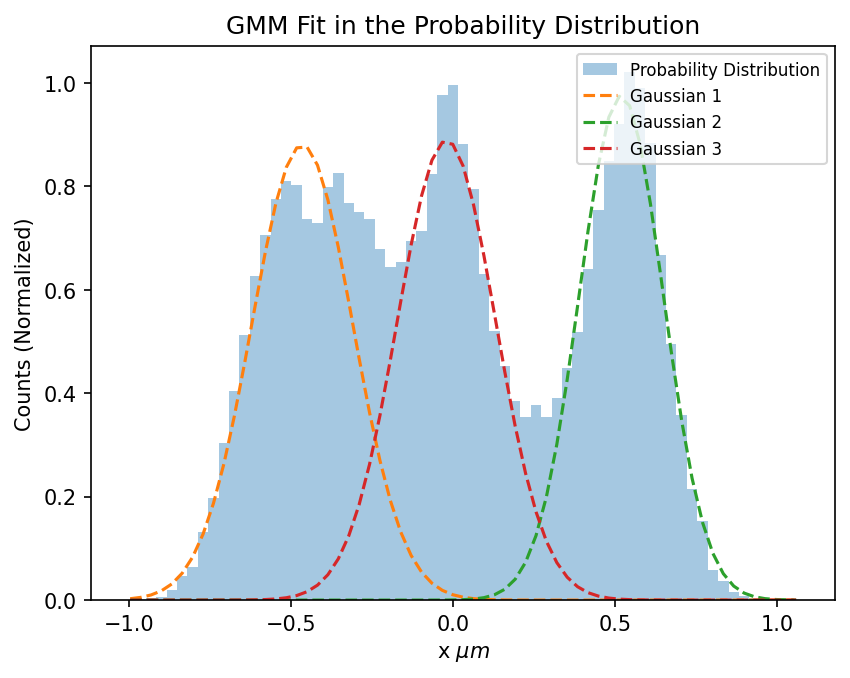

In [5]:
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

x_array = np.asarray(x_array)
x_data = x_array.reshape(-1, 1) # Sample x Feature, in our case the only feature is x

gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(x_data)

means_gmm = gmm.means_.flatten()
stds_gmm = np.sqrt(gmm.covariances_.flatten())
weights_gmm = gmm.weights_

pdf_ex_1 = weights_gmm[0]*norm.pdf(x_ex, means_gmm[0], stds_gmm[0])
pdf_ex_2 = weights_gmm[1]*norm.pdf(x_ex, means_gmm[1], stds_gmm[1])
pdf_ex_3 = weights_gmm[2]*norm.pdf(x_ex, means_gmm[2], stds_gmm[2])

plt.figure(dpi=150)
plt.hist(x_array, bins=65, density=True, alpha=0.4, label="Probability Distribution")
plt.plot(x_ex, pdf_ex_1, '--', label=f"Gaussian 1")
plt.plot(x_ex, pdf_ex_2, '--', label=f"Gaussian 2")
plt.plot(x_ex, pdf_ex_3, '--', label=f"Gaussian 3")
plt.title("GMM Fit in the Probability Distribution")
plt.legend(fontsize=8, loc='upper right')
plt.xlabel(r"x $\mu{}m$")
plt.ylabel(r"Counts (Normalized)")
plt.show()


With this, we can get the central gaussian fit finding the value nearest to 0, meaning the distribution around the trap position

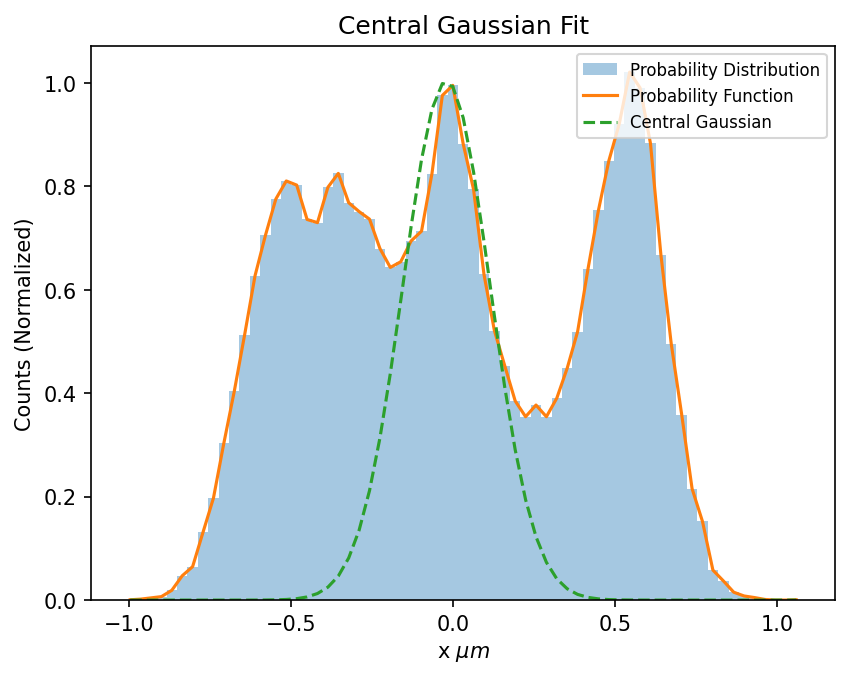

In [6]:
id_central = abs(means_gmm).argmin() # Nearest to 0
# Fit the height with the one of the distribution
id_zero_data = abs(x_ex).argmin()
id_zero_pdf = abs(x_ex).argmin()
pdf_ex_central = weights_gmm[id_central]*norm.pdf(x_ex, means_gmm[id_central], stds_gmm[id_central]) # Initial
k = counts_ex[id_zero_data] / pdf_ex_central[id_zero_pdf] # Scaling Factor - Fit Point
pdf_ex_central = weights_gmm[id_central]*norm.pdf(x_ex, means_gmm[id_central], stds_gmm[id_central]/k)
#pdf_ex_central = k*weights_gmm[id_central]*norm.pdf(x_ex, means_gmm[id_central], stds_gmm[id_central])

plt.figure(dpi=150)
plt.hist(x_array, bins=65, density=True, alpha=0.4, label="Probability Distribution")
#plt.scatter([x_ex[id_zero_data], x_ex[id_zero_pdf]], [counts_ex[id_zero_data], pdf_ex_central[id_zero_pdf]], color="r")
plt.plot(x_ex, counts_ex, label="Probability Function")
plt.plot(x_ex, pdf_ex_central, '--', label=f"Central Gaussian")
plt.title("Central Gaussian Fit")
plt.xlabel(r"x $\mu{}m$")
plt.ylabel(r"Counts (Normalized)")
plt.legend(fontsize=8, loc='upper right')
plt.show()

Now we implement the same process to the range of frequencys which we want to analyze, hopefully getting data regarding the tails.

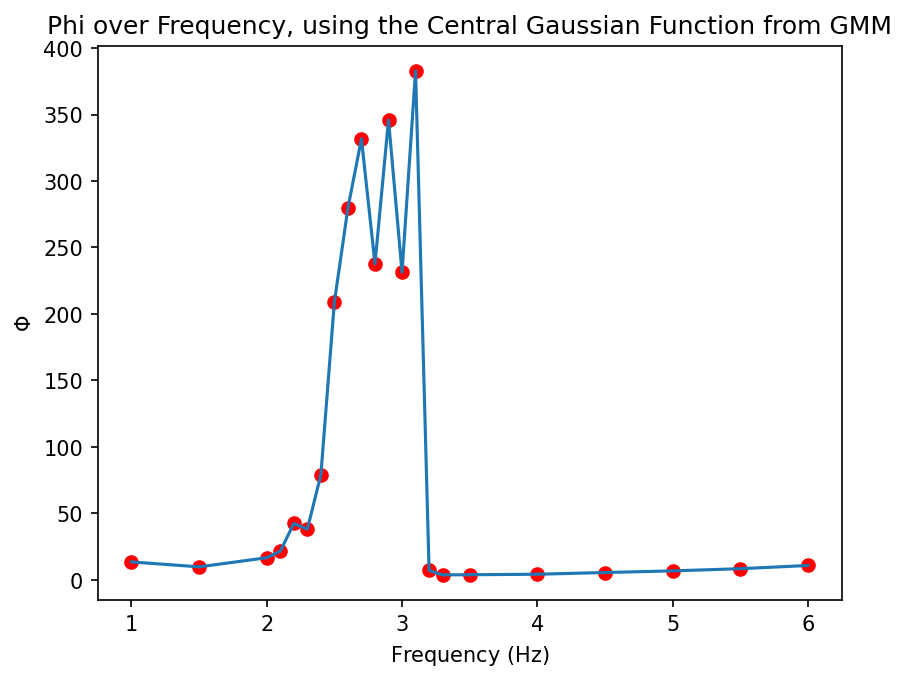

In [7]:
freqs_gaus = [1, 1.5, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.5, 4, 4.5, 5, 5.5, 6]
phi = np.zeros(len(freqs_gaus))

plt.figure(dpi=150)
for idx, freq in enumerate(freqs_gaus):
    
    dir_data = r"./mag&freq/" + f"/data_fmag{fmag}_ffreq{freq}_{tot_runs}runs/" + "results.csv"
    data = pd.read_csv(dir_data)
    x_array = np.zeros(tot_runs * n_data)
    
    for i in range(tot_runs):
        part = data[data["run_number"] == i + 1]
        x_part = np.array(part.x_pos.tolist())
        x_part = x_part - x_part[0]
        x_array[n_data * i : n_data * (i + 1)] = x_part[t_stat_idx:-1]
    
    # Data
    counts_freq, bin_edges = np.histogram(x_array, bins=num_bins, density=True)
    x_freq = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Gaussian Fit
    x_array = np.asarray(x_array)
    x_data = x_array.reshape(-1, 1) # Sample x Feature, in our case the only feature is x
    gmm = GaussianMixture(n_components=3, random_state=0)
    gmm.fit(x_data)
    means_gmm = gmm.means_.flatten()
    stds_gmm = np.sqrt(gmm.covariances_.flatten())
    weights_gmm = gmm.weights_
    id_central = abs(means_gmm).argmin()
    id_scale = abs(x_freq).argmin()
    pdf_central = weights_gmm[id_central]*norm.pdf(x_freq, means_gmm[id_central], stds_gmm[id_central])
    k = counts_freq[id_zero_data] / pdf_ex_central[id_zero_pdf] # Scaling Factor - Fit Point
    pdf_central = weights_gmm[id_central]*norm.pdf(x_ex, means_gmm[id_central], stds_gmm[id_central]/k)

    phi[idx] = sum((pdf_central - counts_freq)**2) # Difference squared, in all the points of data
    
# Plot Phi Parameter
plt.plot(freqs_gaus, phi)
plt.scatter(freqs_gaus, phi, color="r")
plt.title(f"Phi over Frequency, using the Central Gaussian Function from GMM")
plt.xlabel(r"Frequency ($\text{Hz}$)")
plt.ylabel(r"$\Phi$")
plt.show()